# Import Libraries


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, accuracy_score, recall_score

from sklearn.metrics import precision_recall_curve, auc
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV

# Load and Explore the Dataset


In [8]:
# Load the dataset
df = pd.read_csv("creditcard.csv")

# Change the columm Class to Fraud
df.rename(columns={'Class': 'Fraud'}, inplace=True)

# Display first few rows
df.head()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Debugging
# Display basic statistics
print("\nDataset Statistics:\n", df.describe())

# Check class distribution
print("\nClass Distribution:\n", df['Fraud'].value_counts())


Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Fraud     0
dtype: int64

Dataset Statistics:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.5

# Visualization of Dataset


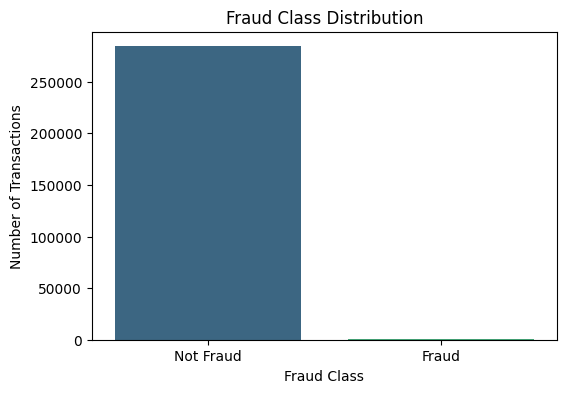

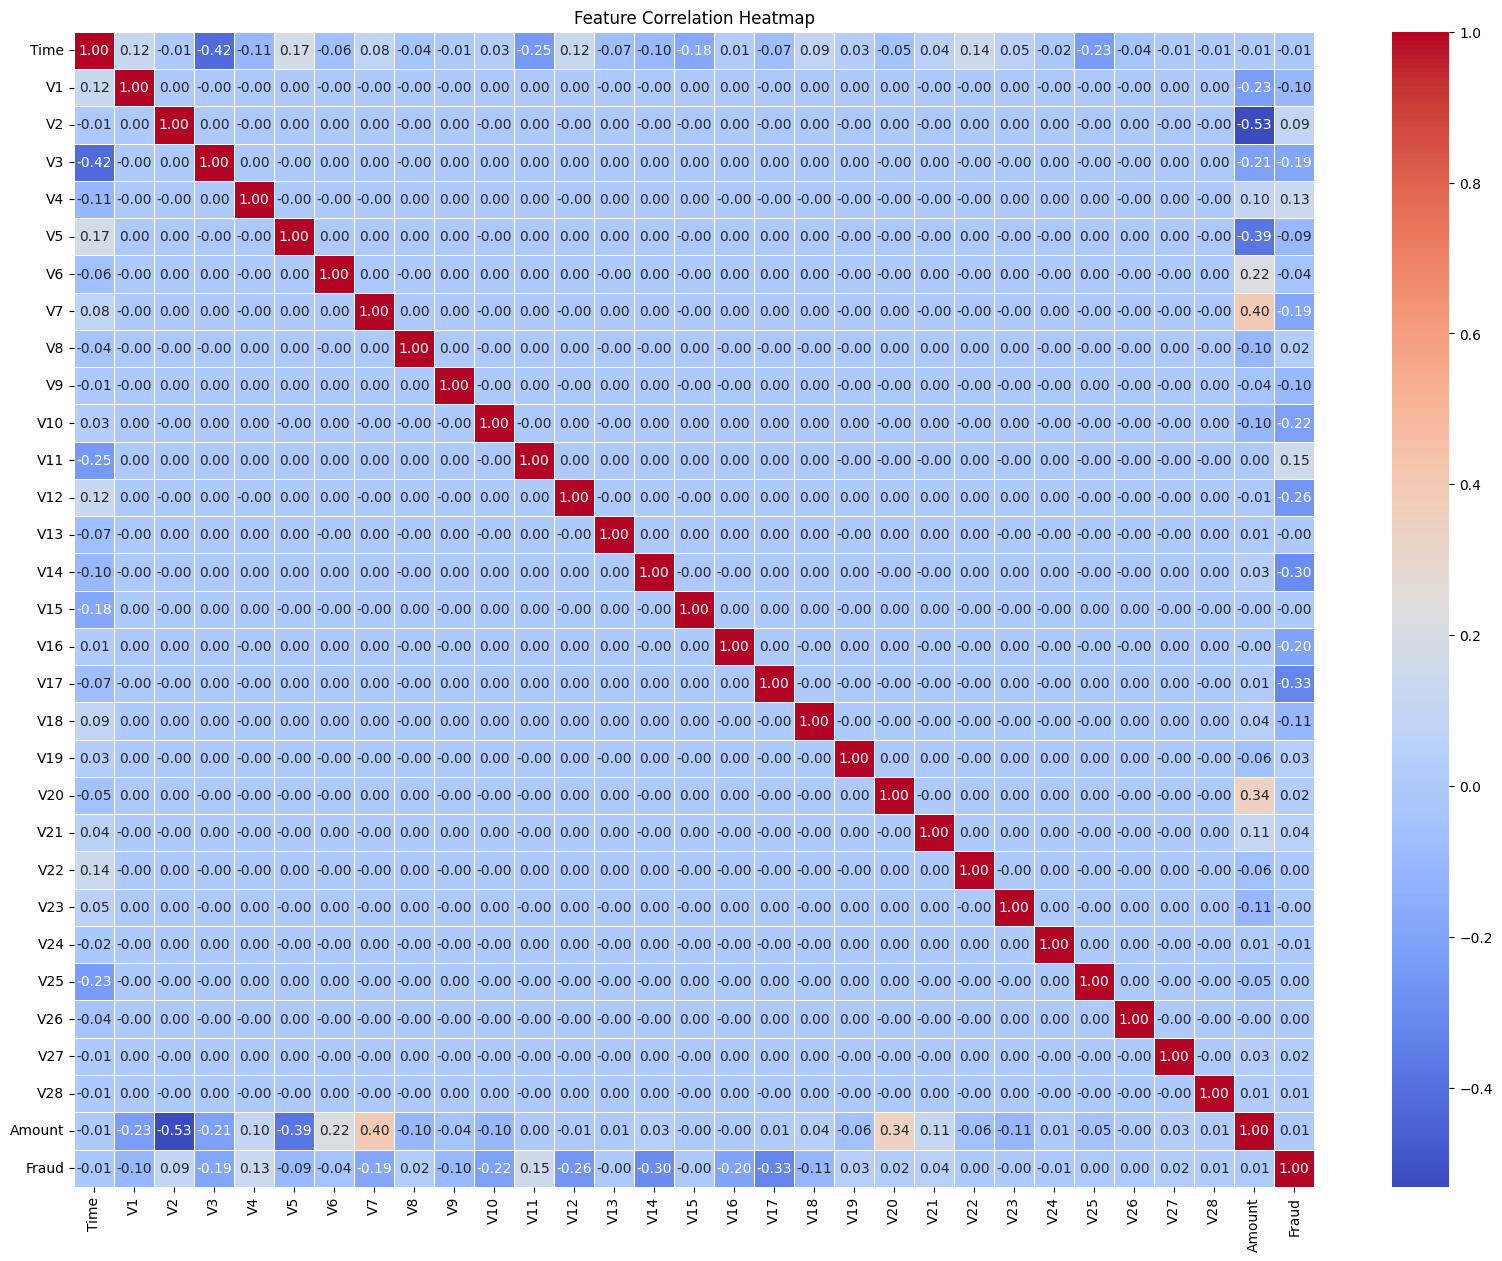

In [9]:
# Fraud Class Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=df["Fraud"].value_counts().index,
            y=df["Fraud"].value_counts().values,
            hue=df["Fraud"].value_counts().index,
            palette="viridis",
            legend=False)

plt.xticks([0, 1], ["Not Fraud", "Fraud"])
plt.ylabel("Number of Transactions")
plt.xlabel("Fraud Class")
plt.title("Fraud Class Distribution")
plt.show()

# Select only numeric columns for correlation computation
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Feature Correlation Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Data Preprocessing

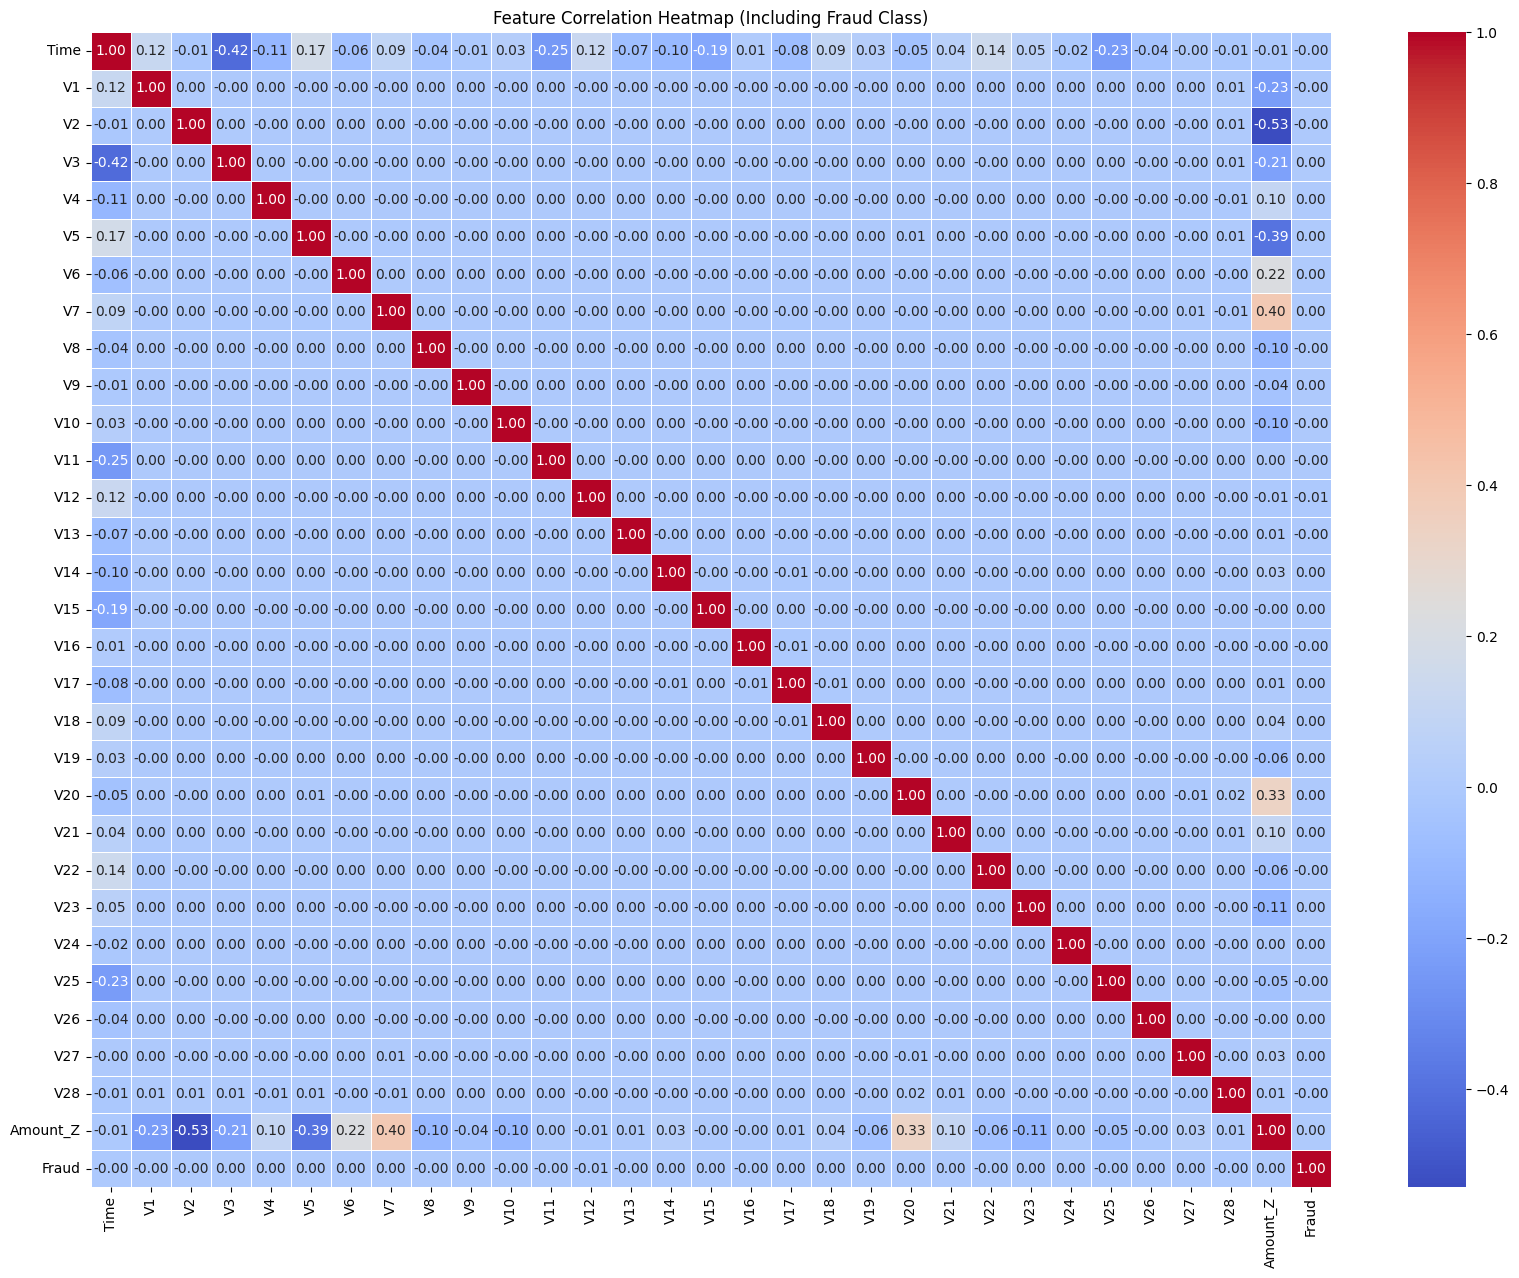

In [10]:
# Feature Engineering - Alternative Features
# 1. Standardize Transaction Amount
scaler = StandardScaler()         # Swap scaler to emphasize higher amounts
df["Amount_Z"] = scaler.fit_transform(df[["Amount"]])


df.drop(columns=["Amount"], inplace=True)

# Separate features and target variable
df = df.dropna(subset=['Fraud'])  # Remove rows where 'Fraud' is NaN
X = df.drop(columns=['Fraud'])
y = df['Fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to DataFrame for feature selection (without SMOTE)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Normalize features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Add Fraud column back for correlation analysis
X_train['Fraud'] = y_train

# Compute correlation matrix including Fraud
correlation_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Including Fraud Class)")
plt.show()

# Drop Fraud column again for model training
X_train = X_train.drop(columns=['Fraud'])

# RFE Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")

rfe = RFECV(rf_model,cv=3,scoring="neg_mean_squared_error", verbose=2)
rfe.fit(X_train,y_train)

selected_features_rfe = X_train.columns[rfe.get_support()]
print("RFE Selection Chosen Features:", selected_features_rfe)

# ------------------------
# Comparision Portion
# ------------------------

from sklearn.metrics import accuracy_score

# Train model with all features
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_recall_class1 = recall_score(y_test, y_pred, pos_label=1)

# Train with RFE features
# Note: Y class doesn't need to be selected
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

rf_model.fit(X_train_rfe, y_train)
y_pred_rfe = rf_model.predict(X_test_rfe)

rfe_accuracy = accuracy_score(y_test, y_pred_rfe)
rfe_recall_class1 = recall_score(y_test, y_pred_rfe, pos_label=1)


# ------------------------
# Print Results
# ------------------------

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline Class 1 Recall: {baseline_recall_class1:.4f}")
print(f"RFE Selection Accuracy: {rfe_accuracy:.4f}")
print(f"RFE Selection Class 1 Recall: {rfe_recall_class1:.4f}")




Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


# Feature Importance


Retained Top Features: ['V2', 'V3', 'V4', 'V7', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17']


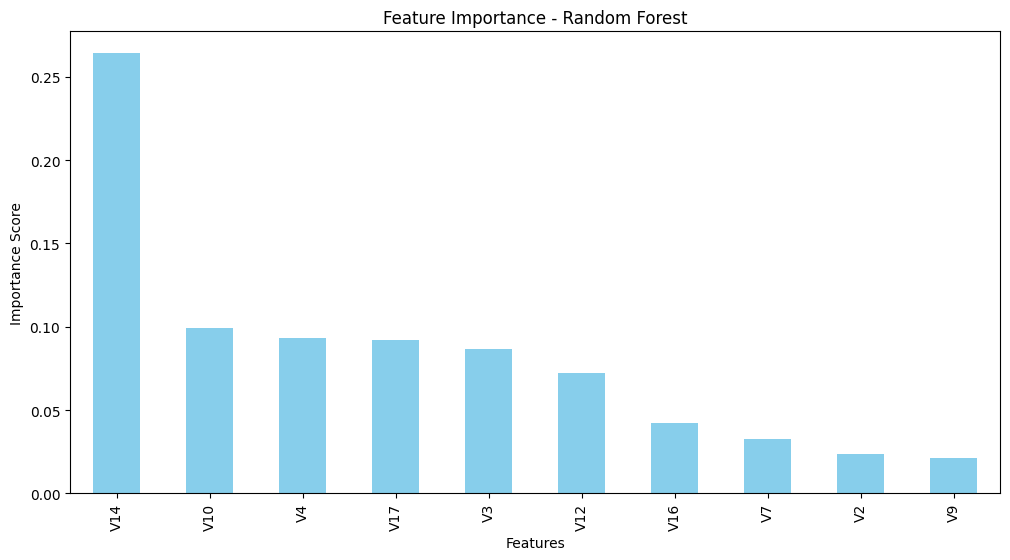

In [11]:
# # Define the selected features
# selected_features_rfe = ['V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V13', 'V14',
#                          'V16', 'V17', 'V19', 'V20', 'V26', 'Amount_Z']

# # Select only the chosen features for training and testing
# X_train = X_train[selected_features_rfe]
# X_test = X_test[selected_features_rfe]

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Train temporary Random Forest model for feature selection
rf_temp = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced")
rf_temp.fit(X_train_np, y_train_np)

# Extract Feature Importances
feature_importances = rf_temp.feature_importances_

# Convert to NumPy array for speed
feature_importances_np = np.array(feature_importances)

# Set a threshold (keep features with importance > 0.02)
selected_features_idx = np.where(feature_importances_np > 0.02)[0]

# Retain only important features
X_train_np = X_train_np[:, selected_features_idx]
X_test_np = X_test_np[:, selected_features_idx]

# Get feature names (if needed)
top_features = np.array(X.columns)[selected_features_idx]
print("\nRetained Top Features:", list(top_features))

# Create a Pandas Series for easy sorting
feature_importance_series = pd.Series(feature_importances_np[selected_features_idx], index=top_features)

# Sort in descending order and plot
plt.figure(figsize=(12, 6))
feature_importance_series.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

# Hyperparameter Tuning

In [12]:
# Define the parameter grid (smaller search space)
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize the Random Forest model with fewer trees
rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight="balanced", n_jobs=-1)

# Use HalvingGridSearchCV for faster tuning
halving_search = HalvingGridSearchCV(
    rf, param_grid, cv=3, factor=3, n_jobs=-1, verbose=1, random_state=42
)

# Fit the model with fewer trees for faster tuning
halving_search.fit(X_train_np, y_train_np)

# Get best parameters and retrain with full trees
best_params = halving_search.best_params_
best_params['n_estimators'] = 300  # Increase trees for final model

# Train final model with optimal hyperparameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train_np, y_train_np)

# Print final model score
print("Best Parameters:", best_params)

# Predict the probabilities for the positive class
y_pred_prob = best_rf_model.predict_proba(X_test_np)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test_np, y_pred_prob)

print("AUC Score:", auc_score)
print("Final Model Accuracy:", best_rf_model.score(X_test_np, y_test_np))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 2812
max_resources_: 227845
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 2812
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 1
n_candidates: 36
n_resources: 8436
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 2
n_candidates: 12
n_resources: 25308
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 3
n_candidates: 4
n_resources: 75924
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 227772
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
AUC Score: 0.9712934836286793
Final Model Accuracy: 0.9996664442961974


# Model Evaluation




Best Threshold for F1-Score: 0.50

Random Forest Accuracy: 0.9997


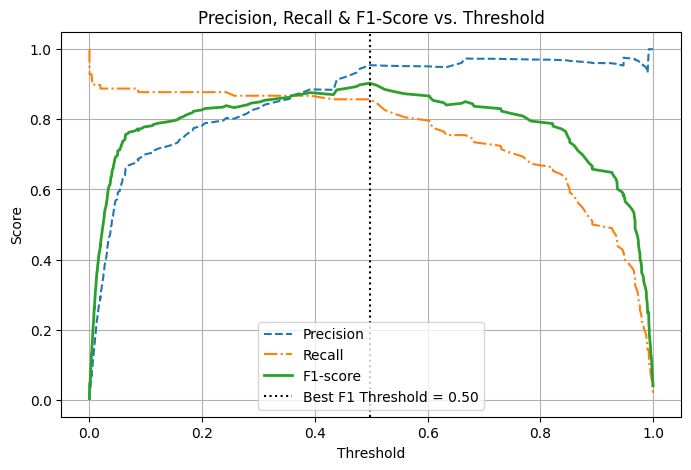


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.86      0.90        98

    accuracy                           1.00     56962
   macro avg       0.98      0.93      0.95     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56860     4]
 [   14    84]]

Precision-Recall AUC Score: 0.8609644281317836


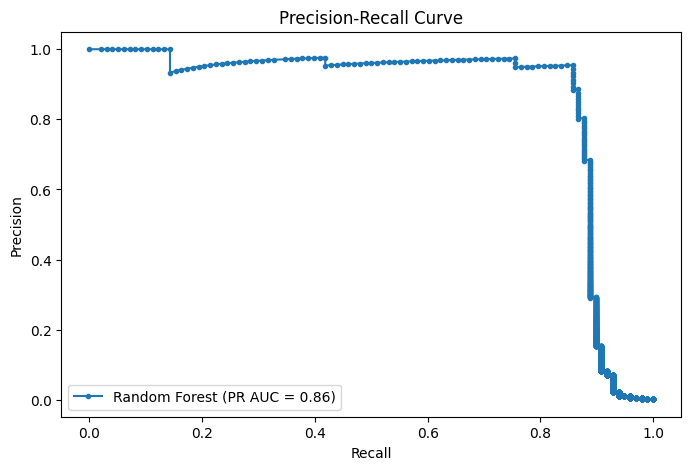

In [13]:
# Model Evaluation (Updated)
# Make Predictions
y_pred_proba = best_rf_model.predict_proba(X_test_np)[:, 1]  # Get probability scores

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_np, y_pred_proba)

# Find Best Threshold (Maximizing F1-Score)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

print(f"\nBest Threshold for F1-Score: {best_threshold:.2f}")

# Convert Probabilities into Binary Predictions Using Best Threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test_np, y_pred_adjusted)

# Print accuracy
print(f"\nRandom Forest Accuracy: {accuracy:.4f}")

# Plot Precision-Recall vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, recall[:-1], label="Recall", linestyle="-.")
plt.plot(thresholds, f1_scores[:-1], label="F1-score", linestyle="-", linewidth=2)
plt.axvline(best_threshold, color='black', linestyle="dotted", label=f"Best F1 Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1-Score vs. Threshold")
plt.legend()
plt.grid()
plt.show()

# Apply New Threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# Evaluate Performance
print("\nClassification Report")
print(classification_report(y_test_np, y_pred_adjusted))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_adjusted))

# Compute Precision-Recall AUC
pr_auc = auc(recall, precision)
print("\nPrecision-Recall AUC Score:", pr_auc)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label="Random Forest (PR AUC = {:.2f})".format(pr_auc))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# # Out-of-Bag Score (Alternative Validation)
# rf_oob_model = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42, n_jobs=-1)
# rf_oob_model.fit(X_train_np, y_train_np)

# # Print OOB Score
# print("\nOOB Score:", rf_oob_model.oob_score_)

# ROC Curve Visualization

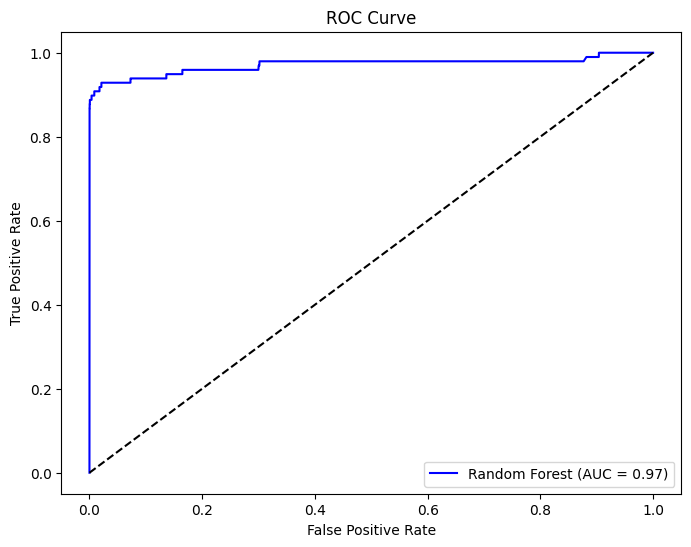

In [14]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Random Forest (AUC = {:.2f})".format(roc_auc_score(y_test_np, y_pred_proba)), color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()